# Imports

In [ ]:
### Imports
import time
import os
import re
import math
import cv2 
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from google.colab import drive
from google.colab.patches import cv2_imshow
from skimage import img_as_float
from skimage.measure import compare_mse as mse
from pylab import *

### Image comparaison
import sys
from scipy.linalg import norm
from scipy import sum, average

### Progress bar imports
from tqdm.notebook import tqdm
# from tqdm import tqdm
from time import sleep

### Mounting drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Main Methods

In [ ]:
### Main methods

### File processing

# This method puts files into lists and return them as one list with all images in the folder
def loadImages(path):
    image_files = sorted([os.path.join(path,file)
                          for file in os.listdir(path)
                          if file.endswith('.jpg')])
    return image_files

# This method puts files into lists and return them as one list with all images in the folder
def loadVideo(path):
    video_files = sorted([os.path.join(path,file)
                          for file in os.listdir(path)
                          if file.endswith('.mp4')])
    return video_files

# Will read images from path_url and output the dimensions
def readImages(training_images):
  images = []
  for i in tqdm(range(len(training_images))):
    images.append(cv2.imread(training_images[i]))
  print('Original Dimenstions :',images[0].shape)
  return images

### Image Processing
def resizeImage(images,x,y):
  # INTER_NEAREST
  # INTER_LINEAR 
  # INTER_AREA
  resList = []
  for i in range(0,len(images)):
    img = images[i]
    res = cv2.resize(img, dsize=(x, y), interpolation=cv2.INTER_NEAREST)
    resList.append(res)
  print('Resized Dimenstions :',resList[0].shape)
  return resList

# Convert images to gray scale and add them to list
def toGrayScale(images):
  gray_imgs = []
  for i in range(0,len(images)):
    gray = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    gray_imgs.append(gray)
  return gray_imgs

def normalize(arr):
    rng = arr.max()-arr.min()
    amin = arr.min()
    return (arr-amin)*255/rng

def histEq(imgs):
  equ_list = []
  for img in imgs:
    equ_list.append(cv2.equalizeHist(img))
  return equ_list

### Video Processing
def video_to_frames(input_loc, output_loc):
    try:
        os.mkdir(output_loc)
    except OSError:
        pass
    # Log the time
    time_start = time.time()
    # Start capturing the feed
    cap = cv2.VideoCapture(input_loc)
    # Find the number of frames
    video_length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - 1
    print ("Number of frames: ", video_length)
    count = 0
    print ("Converting video..\n")
    # Start converting the video
    while cap.isOpened():
        # Extract the frame
        ret, frame = cap.read()
        # Write the results back to output location.
        cv2.imwrite(output_loc + "/%#05d.jpg" % (count+1), frame)
        count = count + 1
        # If there are no more frames left
        if (count > (video_length-1)):
            # Log the time again
            time_end = time.time()
            # Release the feed
            cap.release()
            # Print stats
            print ("Done extracting frames.\n%d frames extracted" % count)
            print ("It took %d seconds forconversion." % (time_end-time_start))
            break


### Image difference functions

# Calculates the root mean square error (RSME) between two images (OLD function)
def rmsDiff(img1,img2):
  # normalize to compensate for exposure difference
  img1 = normalize(img1)
  img2 = normalize(img2)
  # # calculate difference 
  # diff = img1 - img2
  mse_val = math.sqrt(mse(img_as_float(img1),img_as_float(img2)))
  return mse_val

def absDiff(img1, img2):
  # normalize to compensate for exposure difference
  img1 = normalize(img1)
  img2 = normalize(img2)
  # calculate the difference and its norms
  diff = img1 - img2
  m_norm = np.sum(abs(diff)) 
  # m_norm = np.sum(cv2.absdiff(img1,img2))
  return m_norm

def get_img_diff(img1, img2):
  diff = cv2.absdiff(img1, img2)
  # m_norm = np.sum(abs(diff)) 
  return cv2_imshow(diff),diff

## Plotting fucntion
def plot_rms(dataset,goal_img,is_val = False):
  computed_rms = []
  for i in range(0,len(dataset)):
    computed_rms.append(rmsDiff(dataset[i],goal_img))
  if is_val == True:
    plt.plot(computed_rms)
    plt.title("RMS Plot")
    plt.xlabel("Image count")
    plt.ylabel("RMS")
  else: 
    return computed_rms

def plot_ridf(dataset,goal_img,is_val = False):
  computed_ridf = []
  for i in range(0,len(dataset)):
    computed_ridf.append(absDiff(dataset[i],goal_img))
  if is_val == True:
    plt.plot(computed_ridf)
    plt.title("RIDF Plot")
    plt.xlabel("Image count")
    plt.ylabel("RIDF")
  else: 
    return computed_ridf

### Utilities

# Human sorting functin
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

### Ensemble methods

# Returns the complete processed dataset. 
def prepare_data(init_img_path,x,y):
  # Read image 
  img_data_path = loadImages(init_img_path)
  # Apply human sorting to images
  img_data_path.sort(key=natural_keys)
  # Load images
  data_imgs = readImages(img_data_path)
  # Resize images
  resized_imgs = resizeImage(data_imgs,x,y)
  # Gray scale images
  gray_imgs = toGrayScale(resized_imgs)
  # Apply histeq to grey imgs
  img_eq = histEq(gray_imgs)

  return resized_imgs,gray_imgs,img_eq

# Returns the complete processed dataset. 
def prepare_data_2(init_img_path,x,y):
  # Load images
  data_imgs = readImages(init_img_path)
  # Resize images
  resized_imgs = resizeImage(data_imgs,x,y)
  # Gray scale images
  gray_imgs = toGrayScale(resized_imgs)
  # Apply histeq to grey imgs
  img_eq = histEq(gray_imgs)

  return resized_imgs,gray_imgs,img_eq


# Pickling 
def save_pickle(img_dataset,pickle_name):
  pickle_dict = {}
  pickle_dict['dataset'] = img_dataset
  data_file = open(pickle_name,'ab')
  pickle.dump(pickle_dict,data_file)
  data_file.close()

def load_pickle(pickle_name):
  data_file = open(pickle_name,'rb')
  pickle_dict = pickle.load(data_file)
  return pickle_dict['dataset']

# utility methods
def split_half(a):
    half = len(a) >> 1
    return a[:half], a[half:]

def merge(list1, list2):  
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))] 
    return merged_list

def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

def get_errors(route_coor_dict):
  bp1=[]
  bp2=[]
  for k in list(route_coor_dict.keys()):
    bp2.append(route_coor_dict[k][:2][0][0])
    bp2.append(route_coor_dict[k][:2][1][0])
    bp1.append(route_coor_dict[k][2:][0][0])
    bp1.append(route_coor_dict[k][2:][1][0])
  return bp1,bp2

def plot_boxplots(box_1,box_2,route_name):
  data = [box_1,box_2]
  fig = plt.figure(figsize=(7,5))
  # Creating axes instances
  ax = fig.add_axes([0,0,1,1])
  ax.set_title('Error distrubtion across sweeps vs. test positions for '+ str(route_name),fontsize=17)
  ax.set_ylabel('Error',fontsize=18)
  ax.set_xlabel('Distance',fontsize=18)
  plt.xticks(size = 18)
  # Creating plot
  bp = ax.boxplot(data,whis=1.5,showmeans=True,labels=["73cm","146cm"])
  plt.savefig('boxplot.png', dpi=200,bbox_inches='tight')
  plt.show

# Function that will return a subplot of every sweep against the test positions
# def sweep_plot(main_dataset,sweep_dataset,testpos_dataset,index):
#   ridf_dict={}
#   coor_dict={}
#   test_list=[]
#   for i in range(0,4):
#     ridf_dict['plot'+str(i)] = plot_ridf(sweep_dataset[2],testpos_dataset[2][i])
#   x = np.linspace(-90,90,len(sweep_dataset[2]))
#   fig, ax = plt.subplots()
#   ax.plot(x,ridf_dict['plot0'], '-b', label='pos -2')
#   ax.plot(x,ridf_dict['plot1'], '-r', label='pos -1')
#   ax.plot(x,ridf_dict['plot2'], '-c', label='pos 1')
#   ax.plot(x,ridf_dict['plot3'], '-y', label='pos 2')
#   ax.set_title('RIDF plot ' + str(index) + ': s-r sweep vs test positions')
#   ax.set_ylabel('RFID value')
#   ax.set_xlabel('Angle')
#   # For every position, get the angular error and store them
#   leg = ax.legend()
#   lines = ax.get_lines()
#   for t in range(0,len(lines)):
#     curr_x = lines[t].get_xdata()
#     curr_y = lines[t].get_ydata()
#     v  = merge(abs(curr_x),curr_y)
#     test_list.append(min(v, key=lambda n: (n[1], -n[0])))
#   return test_list

# Function that will return a subplot of every sweep against the test positions
def sweep_plot(main_dataset,sweep_dataset,testpos_dataset,index):
  ridf_dict={}
  coor_dict={}
  test_list=[]
  for i in range(0,4):
    ridf_dict['plot'+str(i)] = plot_ridf(sweep_dataset[2],testpos_dataset[2][i])
  x = np.linspace(-90,90,len(sweep_dataset[2]))
  fig, ax = plt.subplots()
  ax.plot(x,ridf_dict['plot0'], '-b', label='146cm-left')
  ax.plot(x,ridf_dict['plot1'], '-r', label='73cm-left')
  ax.plot(x,ridf_dict['plot2'], '-c', label='73cm-right')
  ax.plot(x,ridf_dict['plot3'], '-y', label='146cm-right')
  ax.set_title('RIDF plot ' + str(index) + ': route sweeps vs. test positions',fontsize=13)
  ax.set_ylabel('RFID value',fontsize=13)
  ax.set_xlabel('Angle',fontsize=13)
  # For every position, get the angular error and store them
  leg = ax.legend()
  plt.savefig('sweep_plot22.png', dpi=300,bbox_inches="tight")
  lines = ax.get_lines()
  for t in range(0,len(lines)):
    curr_x = lines[t].get_xdata()
    curr_y = lines[t].get_ydata()
    v  = merge(abs(curr_x),curr_y)
    test_list.append(min(v, key=lambda n: (n[1], -n[0])))
  return test_list

# Function that will return a subplot of every sweep against the test positions
def sweep_plot_debug(main_dataset,sweep_dataset,testpos_dataset,index):
  ridf_dict={}
  coor_dict={}
  test_list=[]
  for i in range(0,4):
    ridf_dict['plot'+str(i)] = plot_ridf(sweep_dataset[2],testpos_dataset[2][i])
  x = np.linspace(-90,90,len(sweep_dataset[2]))
  fig, ax = plt.subplots()
  ax.plot(x,ridf_dict['plot0'], '-b', label='pos -2')
  ax.plot(x,ridf_dict['plot3'], '-y', label='pos 2')
  ax.plot(x,ridf_dict['plot1'], '-r', label='pos -1')
  ax.plot(x,ridf_dict['plot2'], '-c', label='pos 1')
  ax.set_title('RIDF plot ' + str(index) + ': s-r sweep vs test positions',fontsize=13)
  ax.set_ylabel('RFID value',fontsize=13)
  ax.set_xlabel('Angle',fontsize=13)
  # For every position, get the angular error and store them
  leg = ax.legend()
  lines = ax.get_lines()
  for t in range(0,len(lines)):
    curr_x = lines[t].get_xdata()
    curr_y = lines[t].get_ydata()
    v  = merge(abs(curr_x),curr_y)
    test_list.append(min(v, key=lambda n: (n[1], -n[0])))
  return test_list

# Image functions: `Abs.Diff` vs `R.M.S`
This section will investigate which image computation would be the most optimal one to use and discuss how the RIDF (Rotational image difference function) plots vary.

In [ ]:
### Exp3_ordered dataset path
exp3_ordered_path = "gdrive/MyDrive/Dissertation/exp3_ordered"
exp3_dataset = prepare_data(exp3_ordered_path,250,100)

In [ ]:
### Exp3 video sweep
exp3_sweep_path = "gdrive/MyDrive/Dissertation/frames"
exp3_frames = prepare_data(exp3_sweep_path,250,100)


Original Dimenstions : (1080, 1920, 3)
Resized Dimenstions : (100, 250, 3)


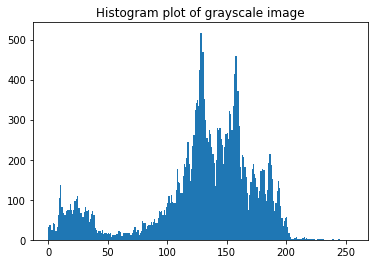

In [ ]:
# Example of plotting the histogram
im = exp3_frames[1][150]
plt.hist(im.ravel(),256,[0,256]);
plt.title("Histogram plot of grayscale image")
plt.show()

## Plots `without normalization`

### Image difference functions

In [ ]:
### Image difference functions

# Calculates the root mean square error (RSME) between two images (OLD function)
def rmsDiff(img1,img2):
  # normalize to compensate for exposure difference
  # img1 = normalize(img1)
  # img2 = normalize(img2)
  # # calculate difference 
  # diff = img1 - img2
  mse_val = math.sqrt(mse(img_as_float(img1),img_as_float(img2)))
  return mse_val

def absDiff(img1, img2):
  # normalize to compensate for exposure difference
  # img1 = normalize(img1)
  # img2 = normalize(img2)
  # calculate the difference and its norms
  diff = img1 - img2
  m_norm = np.sum(abs(diff)) 
  return m_norm

### Plots

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Baseline RMS RIDF plot')

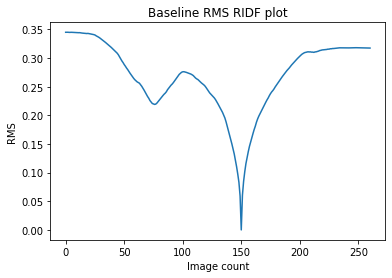

In [ ]:
plot_rms(exp3_frames[1],exp3_frames[1][150],True)
# plt.title("Baseline RMS plot without normalization/HistEq")
plt.title("Baseline RMS RIDF plot")

Text(0.5, 1.0, 'Baseline Abs.Diff RIDF plot')

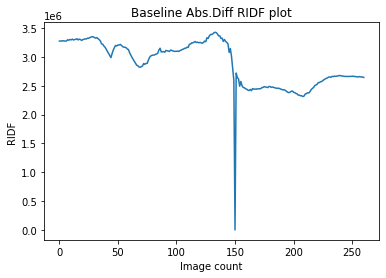

In [ ]:
plot_ridf(exp3_frames[1],exp3_frames[1][150],True)
# plt.title("Abs diff plot without normalization/HistEq")
plt.title("Baseline Abs.Diff RIDF plot")

As you can see in the plots above, the image rotional function plots of the image differences when grayscaled without normalization and histogram equalization yields poor IDF plots. An example of a good plot "reference an example of a good RIDF from paper" which yields a wide minima and tells us enough information.

## Plots `with normalization`

### Image processing methods

In [ ]:
### Image difference functions

# Calculates the root mean square error (RSME) between two images (OLD function)
def rmsDiff(img1,img2):
  # normalize to compensate for exposure difference
  img1 = normalize(img1)
  img2 = normalize(img2)
  # # calculate difference 
  # diff = img1 - img2
  mse_val = math.sqrt(mse(img_as_float(img1),img_as_float(img2)))
  return mse_val

def absDiff(img1, img2):
  # normalize to compensate for exposure difference
  img1 = normalize(img1)
  img2 = normalize(img2)
  # calculate the difference and its norms
  diff = img1 - img2
  m_norm = np.sum(abs(diff)) 
  return m_norm

### Plots

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'RMS RIDF plot with normalisation')

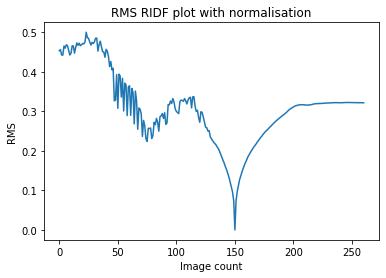

In [ ]:
plot_rms(exp3_frames[1],exp3_frames[1][150],True)
plt.title("RMS RIDF plot with normalisation")

Text(0.5, 1.0, 'Abs diff RIDF plot with normalisation')

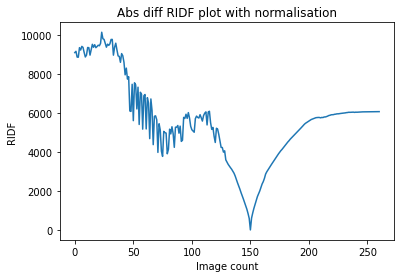

In [ ]:
plot_ridf(exp3_frames[1],exp3_frames[1][150],True)
plt.title("Abs diff RIDF plot with normalisation")

Through simple linear normalization across the images, we notice a significant improvement in the plots where the minima is widened in both operations. However, we still observe significant noise at the beginning of the plot. We will try to investigate further about what this noise represents by inspecting the difference image between the goal image and the view at the images yielding the noise. Through observation, we can comptue the absolute difference between the images between 50-100 against the 150th image and see what is occuring

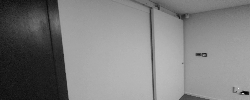

In [ ]:
# image at current view
cv2_imshow(exp3_frames[1][50])

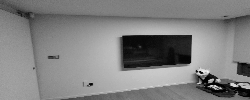

In [ ]:
# goal image
cv2_imshow(exp3_frames[1][150])

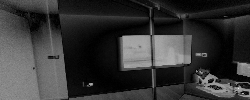

In [ ]:
# the difference image
diff,diff_img = get_img_diff(exp3_frames[1][50],exp3_frames[1][150])

Text(0.5, 1.0, 'Difference image')

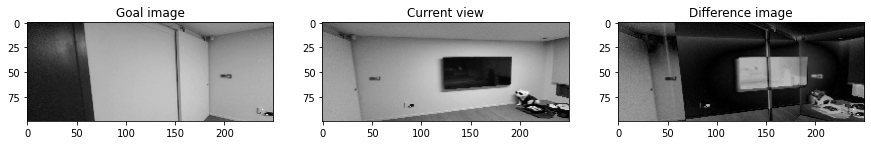

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(exp3_frames[1][50],cmap='gray')
axs[0].set_title('Goal image')

axs[1].imshow(exp3_frames[1][150],cmap='gray')
axs[1].set_title('Current view')

axs[2].imshow(diff_img,cmap='gray')
axs[2].set_title('Difference image')

By computing the difference image between the goal image and the current view at the image match point, we can observe which objects or elements from each image are matching. In this case, we can observe how the predominant white features of the indoor room are matching which would explain the noisy plot. Now, how could we mitigate against this? 

## RMS plot `with histogram equalization`

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: DEPRECATED: skimage.measure.compare_mse has been moved to skimage.metrics.mean_squared_error. It will be removed from skimage.measure in version 0.18.
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'RMS RIDF plot with normalization/histEq')

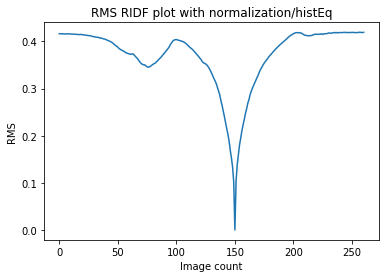

In [ ]:
plot_rms(exp3_frames[2],exp3_frames[2][150],True)
plt.title("RMS RIDF plot with normalization/histEq")

## RIDF plot `with histogram equalization`

Text(0.5, 1.0, 'Abs diff RIDF plot with normalization/histEq')

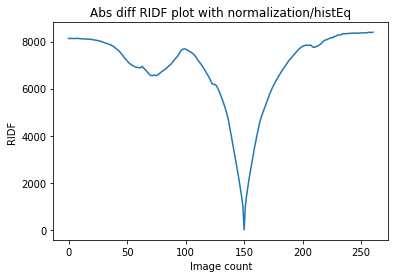

In [ ]:
plot_ridf(exp3_frames[2],exp3_frames[2][150],True)
plt.title("Abs diff RIDF plot with normalization/histEq")



```
# This is formatted as code
```

As you are able to see, the RIDF plot looks much better when computing the absolute difference of the images compared to the root mean square. 

# Short route
The `short_route` dataset contains 11 sweeps with 4 test positions for each sweep. 

In [ ]:
# Loading short_Route pickled data
short_route_test_path = "gdrive/MyDrive/Dissertation/pickled_dataset/short_route_test"
short_route_test = load_pickle(short_route_test_path)
short_route_dataset_path = "gdrive/MyDrive/Dissertation/pickled_dataset/short_route_dataset"
short_route_dataset = load_pickle(short_route_dataset_path)

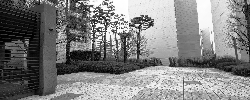

In [ ]:
cv2_imshow(short_route_dataset["short_route4_dataset"][2][150])

In [ ]:
im = short_route_dataset["short_route4_dataset"][2][150]

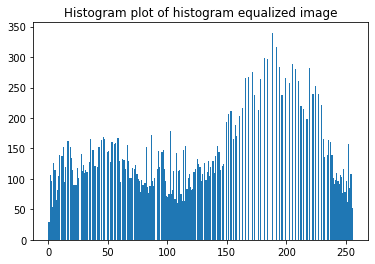

In [ ]:
im = short_route_dataset["short_route4_dataset"][2][150]
plt.hist(im.ravel(),256,[0,256]);
plt.title("Histogram plot of histogram equalized image")
plt.show()

In [ ]:
# Loading 
short_route_walk_path = "gdrive/MyDrive/Dissertation/pickled_dataset/short_route_walk_dataset"
short_route_walk_frames = load_pickle(short_route_walk_path)

In [ ]:
def absDiff_test(img1,img2):
  width = img1.shape[1]
  height = img1.shape[0]
  img1_norm = np.ones((width,height))
  img2_norm = np.ones((width,height))
  img1_norm = cv2.normalize(img1,img1_norm,255,cv2.NORM_L2)
  img2_norm = cv2.normalize(img2,img2_norm,255,cv2.NORM_L2)
  m_norm = np.sum(cv2.absdiff(img1_norm,img2_norm))
  return m_norm

In [ ]:
absDiff_test(short_route_dataset['short_route1_dataset'][2][100],short_route_dataset['short_route1_dataset'][2][101])

5152

In [ ]:
absDiff(short_route_dataset['short_route1_dataset'][2][100],short_route_dataset['short_route1_dataset'][2][101])

1812.643137254902

In [ ]:
short_route_dataset['short_route1_dataset'][1][100].shape

(100, 250)

In [ ]:
plot_ridf(short_route_dataset['short_route1_dataset'][2],short_route_dataset['short_route1_dataset'][2][100],True)

In [ ]:
plot_ridf(short_route_dataset['short_route1_dataset'][2],short_route_dataset['short_route1_dataset'][2][100],True)

In [ ]:
# Plotting the RIDF plots for every sweep against the respective test positions
main_keys = list(short_route_dataset.keys())
test_keys = list(short_route_test.keys())
short_route_coor = {}
for i in range(0,len(main_keys)):
  short_route_coor['pos'+str(i+1)] = sweep_plot(short_route_dataset,short_route_dataset[main_keys[i]],short_route_test[test_keys[i]],i+1)

In [ ]:
for i in range(1,2):
  short_route_coor['pos'+str(i+1)] = sweep_plot(short_route_dataset,short_route_dataset[main_keys[i]],short_route_test[test_keys[i]],i+1)

In [ ]:
# Plotting the RIDF plots for every sweep against the respective test positions
main_keys = list(short_route_dataset.keys())
test_keys = list(short_route_test.keys())
short_route_coor_debug = {}
for i in range(0,len(main_keys)):
  short_route_coor_debug['pos'+str(i+1)] = sweep_plot_debug(short_route_dataset,short_route_dataset[main_keys[i]],short_route_test[test_keys[i]],i+1)

In [ ]:
# Plotting the error distribution for Pos -2,-1 and Pos 1,2 
box1,box2 = get_errors(short_route_coor_debug)
plot_boxplots(box1,box2,"short_route")

In [ ]:
 # Function that will return a subplot of every sweep against the test positions
def sweep_plot_debug(main_dataset,sweep_dataset,testpos_dataset,index):
  ridf_dict={}
  coor_dict={}
  test_list=[]
  for i in range(0,4):
    ridf_dict['plot'+str(i)] = plot_rms(sweep_dataset[2],testpos_dataset[2][i])
  x = np.linspace(-90,90,len(sweep_dataset[2]))
  fig, ax = plt.subplots()
  ax.plot(x,ridf_dict['plot0'], '-b', label='pos -2')
  ax.plot(x,ridf_dict['plot3'], '-y', label='pos 2')
  ax.plot(x,ridf_dict['plot1'], '-r', label='pos -1')
  ax.plot(x,ridf_dict['plot2'], '-c', label='pos 1')
  ax.set_title('RMS plot ' + str(index) + ': s-r sweep vs test positions')
  ax.set_ylabel('RFID value')
  ax.set_xlabel('Angle')
  # For every position, get the angular error and store them
  leg = ax.legend()
  lines = ax.get_lines()
  for t in range(0,len(lines)):
    curr_x = lines[t].get_xdata()
    curr_y = lines[t].get_ydata()
    v  = merge(abs(curr_x),curr_y)
    test_list.append(min(v, key=lambda n: (n[1], -n[0])))
  return test_list

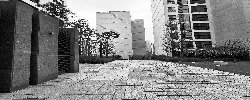

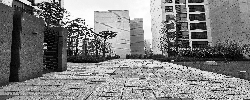

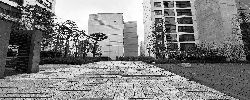

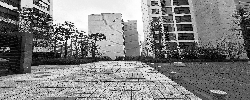

In [ ]:
# short_route_dataset
# short_route_test
len(short_route_test["test_pos2_dataset"][2])
for i in range(4):
  cv2_imshow(short_route_test["test_pos2_dataset"][2][i])

In [ ]:
len(short_route_dataset["short_route2_dataset"][2])

380

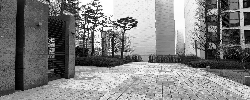

In [ ]:
cv2_imshow(short_route_dataset["short_route2_dataset"][2][147])

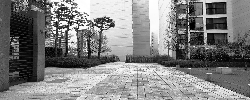

In [ ]:
cv2_imshow(short_route_dataset["short_route2_dataset"][2][170])

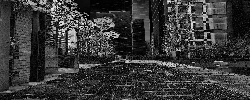

(None, array([[ 48,  39,  13, ...,  14,   3,   1],
        [ 61,  28,  24, ...,  27,  25,  25],
        [ 31,  31,  34, ...,  25,  14,  45],
        ...,
        [ 21,  16,  16, ...,  23,  74, 145],
        [  2,   5,  17, ...,  21,  13,  79],
        [  9,  35,  15, ...,  31,   4,   8]], dtype=uint8))

In [ ]:
get_img_diff(short_route_test["test_pos2_dataset"][2][0],short_route_dataset["short_route2_dataset"][2][170])

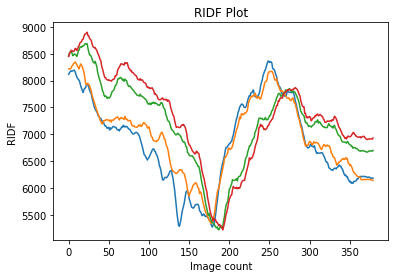

In [ ]:
for i in range(0,4):
  plot_ridf(short_route_dataset["short_route2_dataset"][2],short_route_test["test_pos2_dataset"][2][i],True)

## Affects of `FOV` on angular error.
In this section of then notebook, we will investigate how the angular error varies by adjusting the field of view of the images. Currently, the images at wide-angle posses a total FOV of 120° of visiliblity. We will adjust the field of view by redcuing it down to 100°, 80° and finally 60°. 

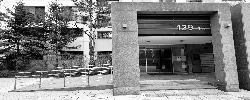

In [ ]:
# How to reduce the FOV of an image?
# First how do the images equate to FOV? 
cv2_imshow(short_route_dataset["short_route1_dataset"][2][0])
# only using the central columns

# Long route
The `long_route dataset` contains 28 sweeps with 4 test positions for each sweep.

In [ ]:
# Loading long_Route pickle data
long_route_test_path = "gdrive/MyDrive/Dissertation/pickled_dataset/long_route_test"
long_route_test = load_pickle(long_route_test_path)
long_route_dataset_path = "gdrive/MyDrive/Dissertation/pickled_dataset/long_route_dataset"
long_route_dataset = load_pickle(long_route_dataset_path)

In [ ]:
# Loading long_route_walk pickled data
long_route_walk_1 = load_pickle("gdrive/MyDrive/Dissertation/pickled_dataset/long_route_walk_1")
long_route_walk_2 = load_pickle("gdrive/MyDrive/Dissertation/pickled_dataset/long_route_walk_2")
long_route_walk = long_route_walk_1[2] + long_route_walk_2[2]

In [ ]:
# RIDF plots
main_keys = list(long_route_dataset.keys())
test_keys = list(long_route_test.keys())
for i in range(0,len(main_keys)):
  sweep_plot(long_route_dataset,long_route_dataset[main_keys[i]],long_route_test[test_keys[i]],i+1)

In [ ]:
# box plot 
main_keys = list(long_route_dataset.keys())
test_keys = list(long_route_test.keys())
long_route_coor = {}
for i in range(0,len(main_keys)):
  long_route_coor['pos'+str(i+1)] = sweep_plot(long_route_dataset,long_route_dataset[main_keys[i]],long_route_test[test_keys[i]],i+1)

In [ ]:
# box plot 
main_keys = list(long_route_dataset.keys())
test_keys = list(long_route_test.keys())
long_route_coor_debug = {}
for i in range(0,len(main_keys)):
  long_route_coor_debug['pos'+str(i+1)] = sweep_plot_debug(long_route_dataset,long_route_dataset[main_keys[i]],long_route_test[test_keys[i]],i+1)

In [ ]:
bp1,bp2 = get_errors(long_route_coor_debug)
plot_boxplots(bp1,bp2,"long_route")

In [ ]:
bp1,bp2 = get_errors(long_route_coor_debug)
plot_boxplots(bp1,bp2,"long_route")

# Snow route
The `snow_route_dataset` contains 11 sweeps with 4 test positions for each sweep.

In [ ]:
# Snow_Route pickle data
snow_route_test_path = "gdrive/MyDrive/Dissertation/pickled_dataset/snow_route_test"
snow_route_test = load_pickle(snow_route_test_path)
snow_route_dataset_path = "gdrive/MyDrive/Dissertation/pickled_dataset/snow_route_dataset"
snow_route_dataset = load_pickle(snow_route_dataset_path)

In [ ]:
# Pickled snow route walk
snow_route_walk_path = "gdrive/MyDrive/Dissertation/pickled_dataset/snow_route_walk_dataset"
snow_route_walk_img = load_pickle(snow_route_walk_path)

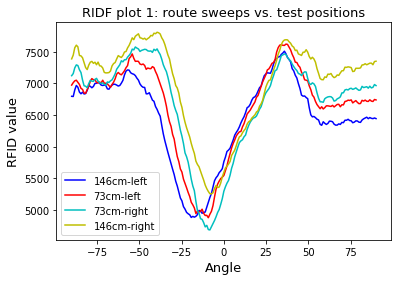

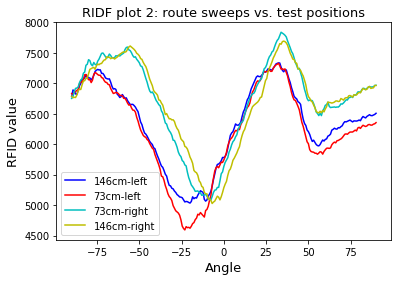

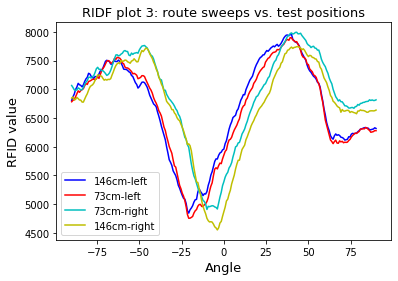

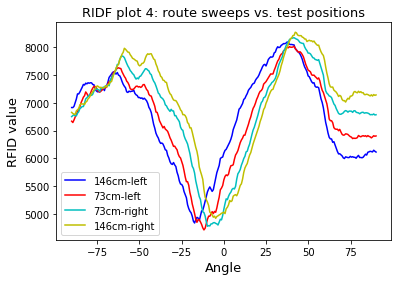

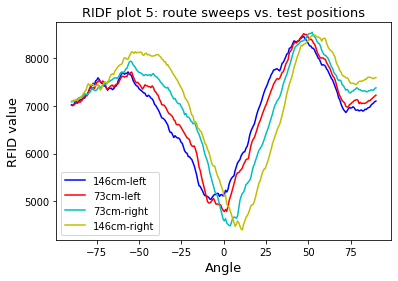

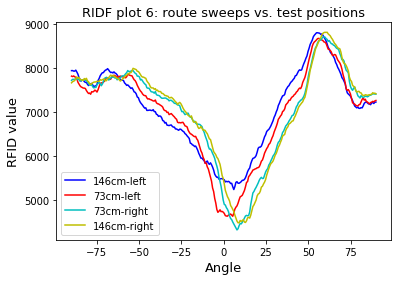

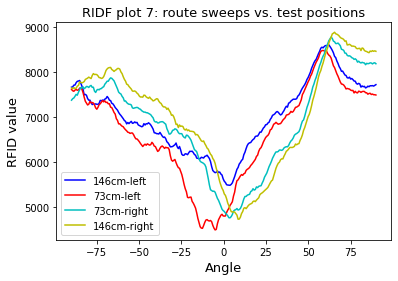

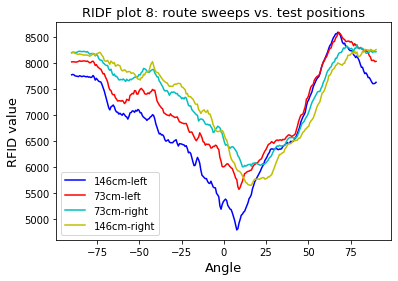

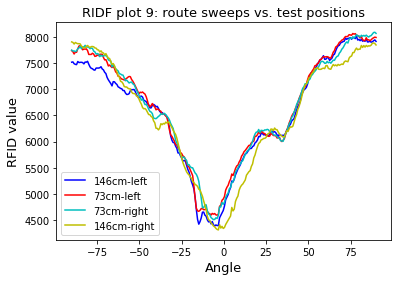

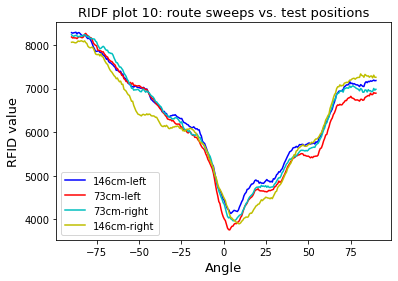

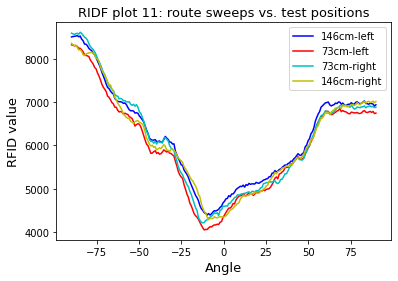

In [ ]:
main_keys = list(snow_route_dataset.keys())
test_keys = list(snow_route_test.keys())
for i in range(0,len(main_keys)):
  sweep_plot(snow_route_dataset,snow_route_dataset[main_keys[i]],snow_route_test[test_keys[i]],i+1)

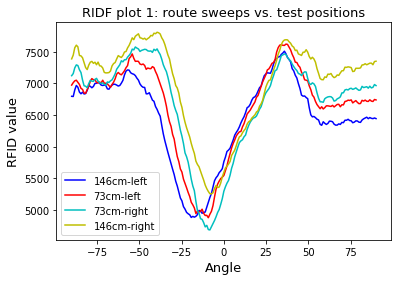

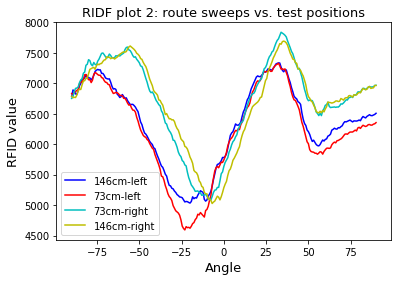

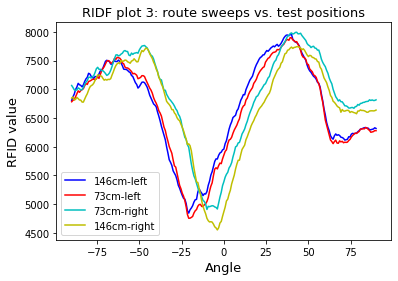

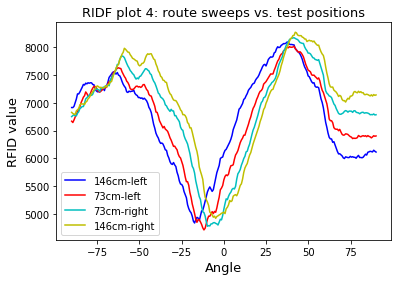

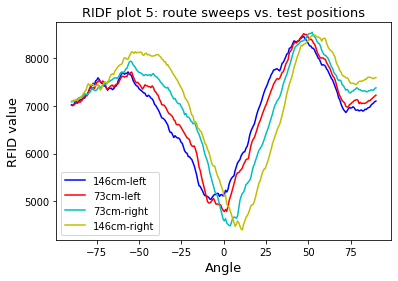

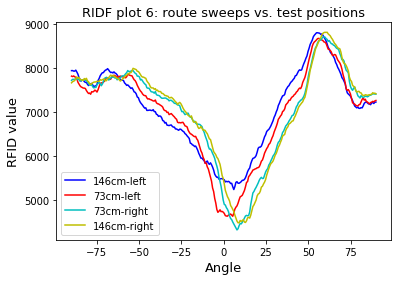

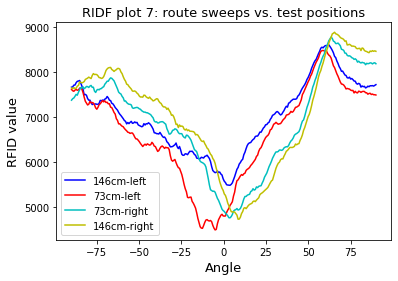

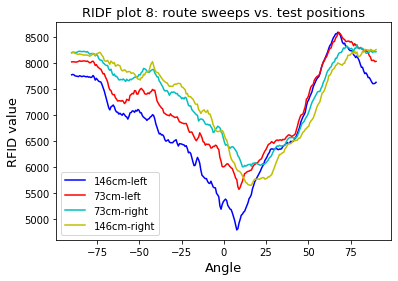

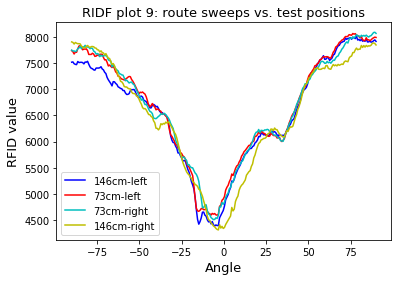

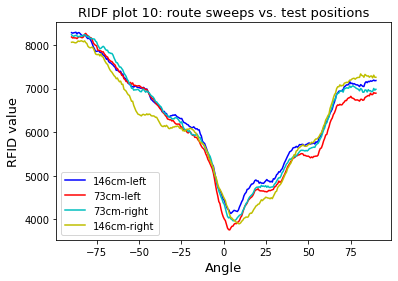

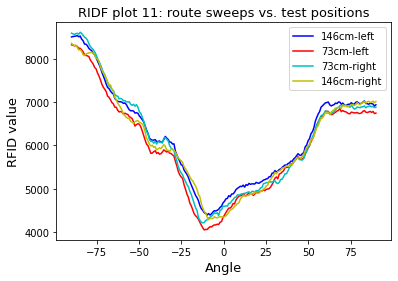

In [ ]:
# box plot 
main_keys = list(snow_route_dataset.keys())
test_keys = list(snow_route_test.keys())
snow_route_coor = {}
for i in range(0,len(main_keys)):
    snow_route_coor['pos'+str(i+1)] = sweep_plot(snow_route_dataset,snow_route_dataset[main_keys[i]],snow_route_test[test_keys[i]],i+1)

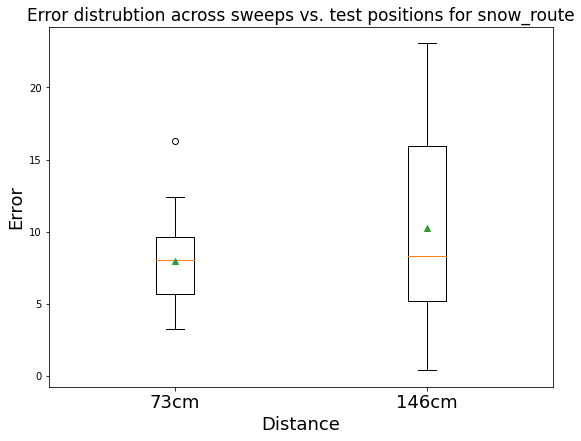

In [ ]:
bp1,bp2=get_errors(snow_route_coor)
plot_boxplots(bp1,bp2,"snow_route")

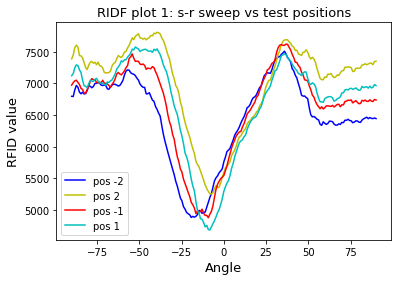

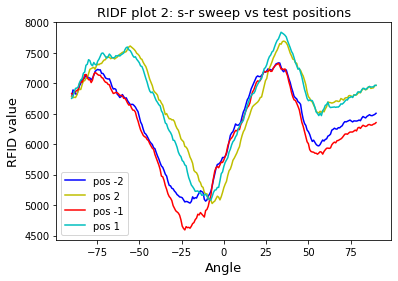

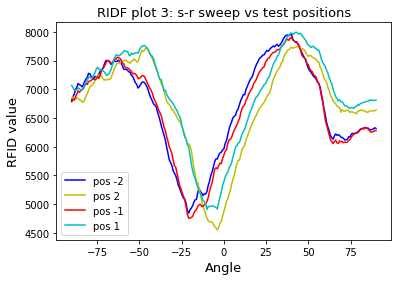

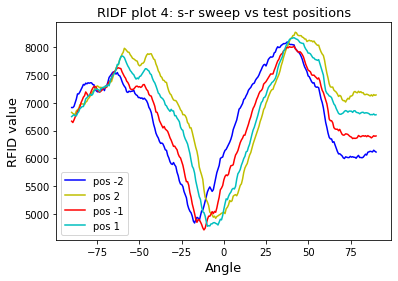

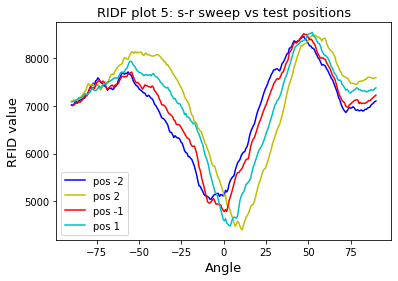

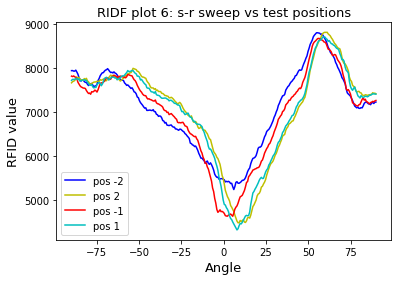

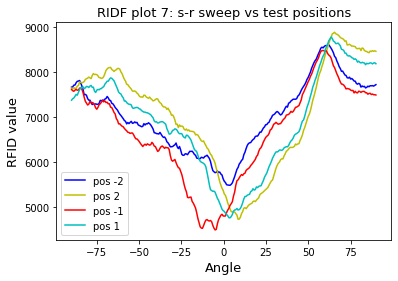

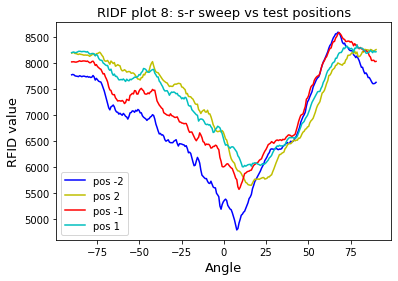

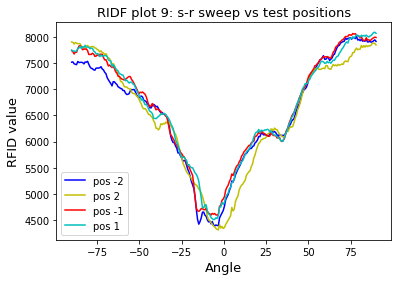

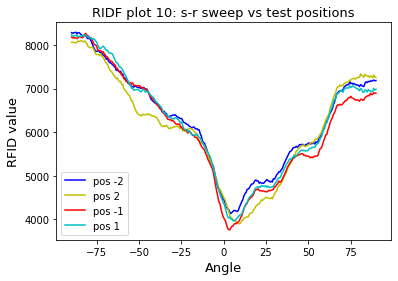

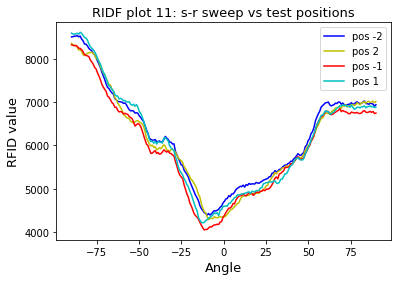

In [ ]:
# box plot 
main_keys = list(snow_route_dataset.keys())
test_keys = list(snow_route_test.keys())
snow_route_coor_debug = {}
for i in range(0,len(main_keys)):
    snow_route_coor_debug['pos'+str(i+1)] = sweep_plot_debug(snow_route_dataset,snow_route_dataset[main_keys[i]],snow_route_test[test_keys[i]],i+1)

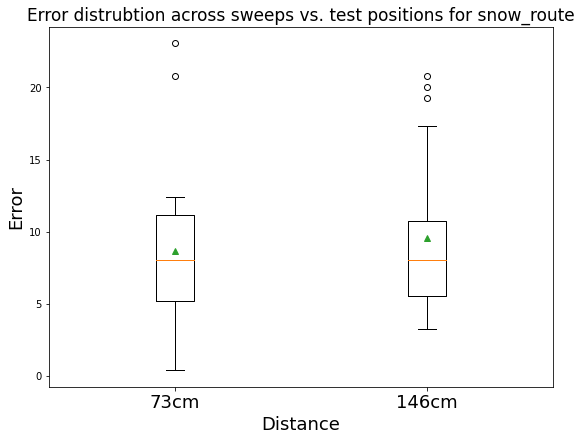

In [ ]:
# Plotting the error distribution for Pos -2,-1 and Pos 1,2 
# Give an example of why. 
# Count of errors within an angle of degrees 
box1,box2 = get_errors(snow_route_coor_debug)
plot_boxplots(box1,box2,"snow_route")

# Alternative image exploration
This section will investigate an alternative image exploration section. 

In [ ]:
exp3_sweep_path = "gdrive/MyDrive/Dissertation/frames"
exp3_frames = prepare_data(exp3_sweep_path,3,3)


Original Dimenstions : (1080, 1920, 3)
Resized Dimenstions : (3, 3, 3)


In [ ]:
cv2_imshow(exp3_frames[2][0])

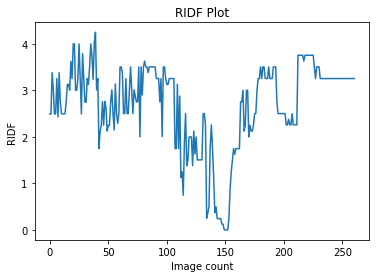

In [ ]:
# 3x3 image
plot_ridf(exp3_frames[2],exp3_frames[2][150],True)

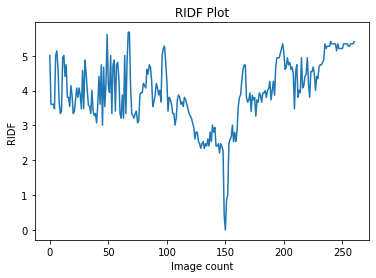

In [ ]:
# 4x4 image
# Run with test positions.
plot_ridf(exp3_frames[2],exp3_frames[2][150],True)

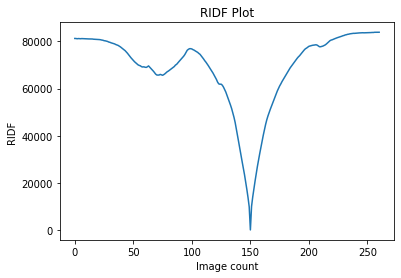

In [ ]:
# 500x500 image
plot_ridf(exp3_frames[2],exp3_frames[2][150],True)

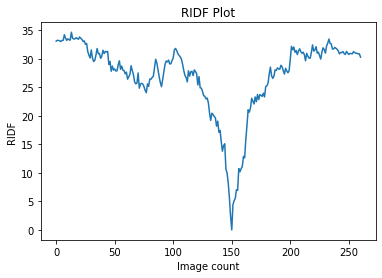

In [ ]:
# 10x10 image
plot_ridf(exp3_frames[2],exp3_frames[2][150],True)

In [ ]:
# divide the distance by the num of pixels. (avg per pixel):ToDo
# Boxplots : plot them. 

In [ ]:
# Plotting the variance in running time of applications per trainining size

In [ ]:
train_10 = [6.673223841,6.77919138,6.683539342,6.630473803,6.32044038,6.423886995,6.903280072,6.72385511,6.548513995,7.610000187]
train_100 = [62.193637994,60.166158419,43.439762776,45.765827468,49.916300233,66.54040226,55.437795383,46.564989159,53.276858385,47.328832735]
train_1000 = [320.622899809,330.86277311,337.548689335,337.70692872,313.791020352,336.977152374,341.764646486,317.626785734,326.551851151,332.417277839]

In [ ]:
train_10 = [6.67,6.78,6.68,6.63,6.32,6.42,6.90,6.72,6.55,7.61]
train_100 = [62.19,60.16,43.44,45.77,49.92,66.54,55.44,46.56,53.28,47.33]
train_1000 = [320.62,330.86,337.55,337.71,313.79,336.98,341.76,317.63,326.55,332.42]

<function matplotlib.pyplot.show>

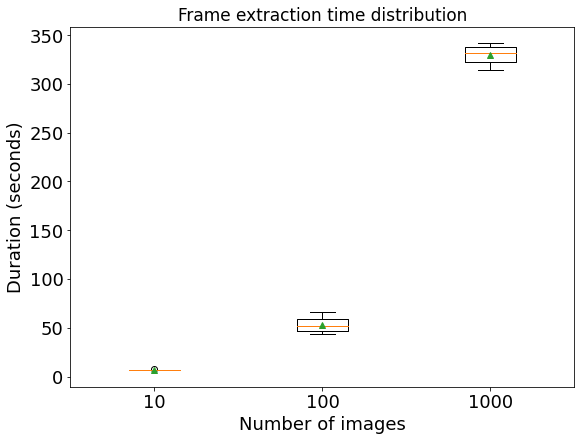

In [ ]:
data=[train_10,train_100,train_1000]
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Frame extraction time distribution',fontsize=17)
ax.set_ylabel('Duration (seconds)',fontsize=18)
ax.set_xlabel('Number of images',fontsize=18)
plt.xticks(size = 18)
plt.yticks(size = 18)
# Creating plot
bp = ax.boxplot(data,whis=1.5,showmeans=True,labels=["10","100","1000"])
plt.savefig('boxplot.png', dpi=200,bbox_inches='tight')
plt.show